In [1]:
import os
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import networkx as nx

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

LABELS = ["sgd", "rmiso", "adam", "mcsag"]

In [2]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [3]:
def get_curve_data(use_pretrained=True, model='one_layer'):
    folder_path = get_folder_path(use_pretrained)
    filenames = [name for name in os.listdir(folder_path) if name.startswith(model.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    optims = [name.split('-')[1] for name in filenames]
    lrs = [float(name.split('-')[2][2:]) for name in filenames]
    algs = [name.split('-')[-1] for name in filenames]
    nodes = [int(name.split('-')[-3][6:]) for name in filenames]
    edges = [int(name.split('-')[-2][6:]) for name in filenames]
    hyperparams = [name.split('-')[3:-3] for name in filenames]
    return [{"optim": op, "lr": l, "alg": alg, "hyp_params": hp, "nodes": nodes, "edges": edges, "curve": torch.load(fp)}
            for op, l, alg, hp, nodes, edges, fp in zip(optims, lrs, algs, hyperparams, nodes, edges, paths)]

In [4]:
def plot(use_pretrained=True, model='one_layer', optimizers=None, title=None, ylim=(50, 100), curve_type='train', algorithm='uniform'):
    assert model in ['resnet', 'densenet'], 'Invalid model name: {}'.format(model)
    assert curve_type in ['train_acc', 'test_acc', 'train_loss', 'test_loss'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    curve_data = get_curve_data(use_pretrained, model=model)
    
    plt.figure()
    if curve_type.split("_")[1] == "acc":
        if title is None:
            title = '{} Accurcy for {} on CIFAR10'.format(curve_type.split("_")[0].capitalize(), model.capitalize())
        plt.ylabel('{} Accuracy %'.format(curve_type.split("_")[0].capitalize()))
    else:
        if title is None:
            title = '{} Loss for {} on CIFAR10'.format(curve_type.split("_")[0].capitalize(), model.capitalize())
        plt.ylabel('{} Loss'.format(curve_type.split("_")[0].capitalize()))

    plt.title(title)
    plt.xlabel('Epoch')
    #plt.xlim(0, 120)
    plt.ylim(ylim)
    
    for curve in curve_data:
        optim = curve['optim']
        lr = curve['lr']
        alg = curve['alg']
        linestyle = '-' if 'rmiso' in optim else '-'
        marker = 'o' if 'rmiso' in optim else ''
        if 'SMM' in optim:
            marker = '*'
        
        if optim in optimizers.keys() and lr in optimizers[optim] and alg == algorithm:
            accuracies = np.array(curve['curve'][curve_type])
            try
            if optim == "rmiso":
                initial_lr = None
                final_lr = None
                delta = curve['hyp_params'][1][5:]
                rho = curve['hyp_params'][0][3:]
                L = 1/lr
                if algorithm == 'uniform':
                    if float(rho) == 0:
                        label = r"MISO-L: {:.4g}".format(L)
                    else:
                        label = r"RMISO-L: {:.4g} - $\rho$: {:.4g}".format(L, float(rho))
                else:
                    label = r"RMISO-L: {:.4g} -$\delta$: {:.4g}".format(L, float(delta))
            elif optim == "sgd":
                label = "SGD-HB-lr: {}".format(lr)
            elif optim =="mcsag":
                if alg == 'uniform':
                    label = "SAG-lr: {}".format(lr)
                else:
                    try:
                        delta = curve['hyp_params'][1][5:]
                        label = r"MCSAG-lr: {} -$\delta$: {:.4g}".format(lr, float(delta))
                    except IndexError:
                        label =r"MCSAG-lr: {}".format(lr)
                        #pass
            else:
                label = f"{optim.upper()}-lr {lr}" 
            plt.plot(accuracies, label=label, ls=linestyle, marker=marker, markevery=10)
        

        
    plt.grid(ls='--')
    plt.legend(ncol=2)
    plt.show()
    save_name = "{}_{}".format(model, curve_type)+".pdf" 
    #plt.savefig(save_name, bbox_inches="tight")

## Resnet - Uniform

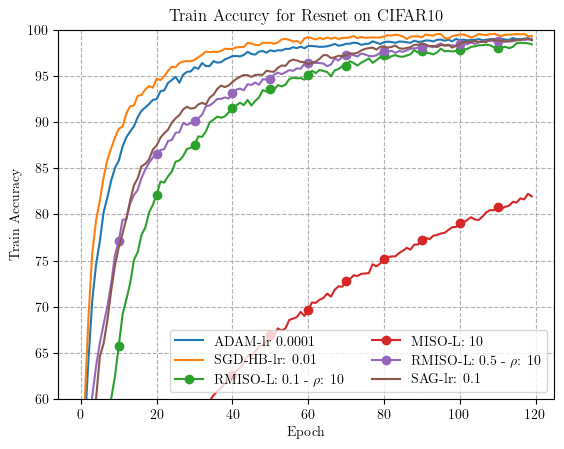

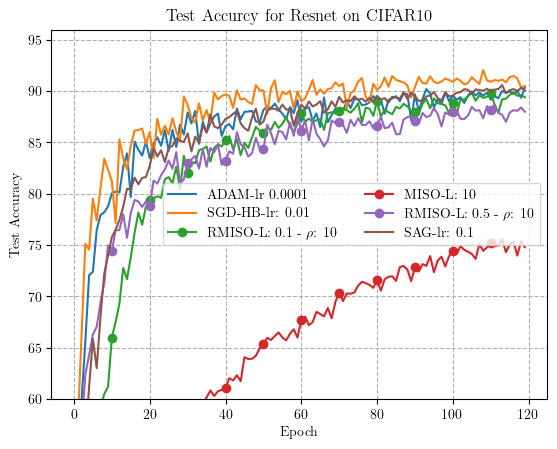

In [10]:
title_train = "Comparison of RMISO learning rates for Resnet on Cifar10: Train Uniform"
title_test = "Comparison of RMISO learning rates for Resnet on Cifar10: Test Uniform"
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10, 2, 0.1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [0.1]}, ylim=(60, 100), curve_type='train_acc')
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10, 2, 0.1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [0.1]}, ylim=(60, 96), curve_type='test_acc')

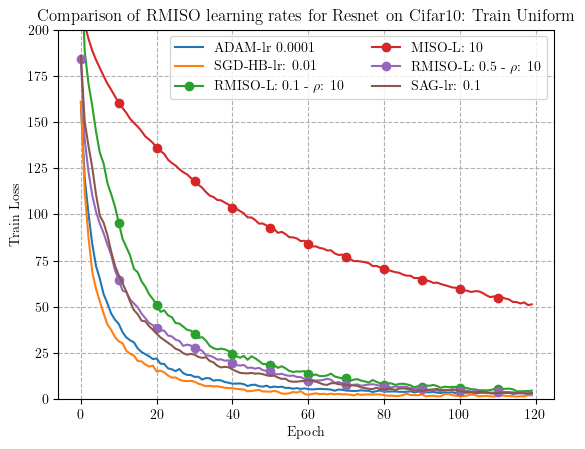

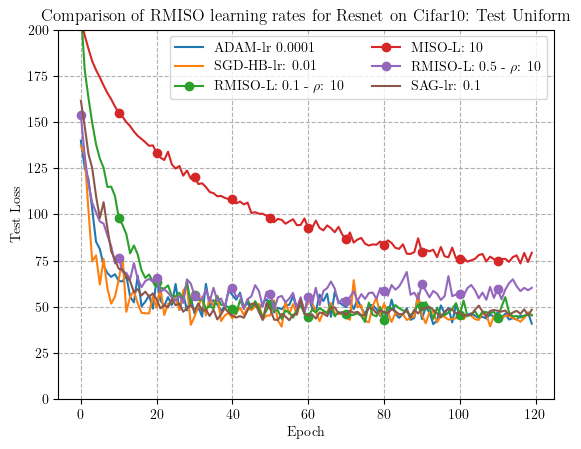

In [6]:
plot(use_pretrained=False, model='resnet', 
     title=title_train, optimizers={"rmiso": [10, 2, 0.1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [0.1]}, ylim=(0, 200), curve_type='train_loss')
plot(use_pretrained=False, model='resnet',
     title=title_test, optimizers={"rmiso": [10, 2, 0.1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [0.1]}, ylim=(0, 200), curve_type='test_loss')

## Resnet - MCMC

RMISO run with lr 2 has prox reg floored at 10
RMISO run with lr 10 has prox reg floored at 100
SAG run with lr 1 has prox reg floored at 10

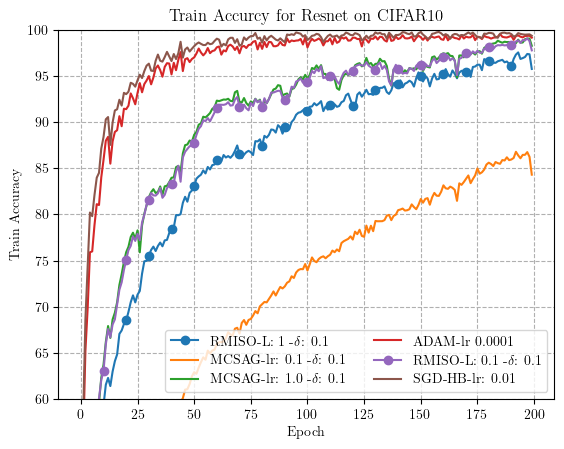

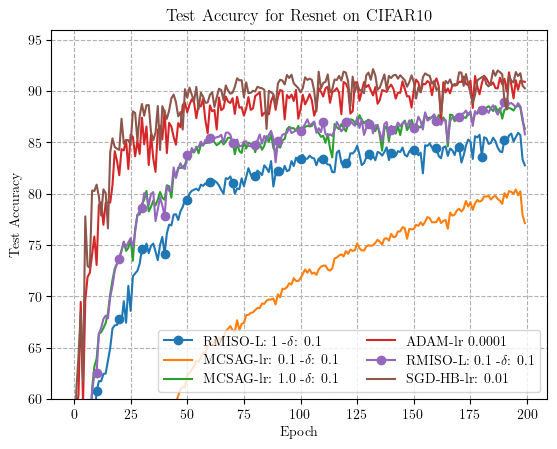

In [9]:
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(60, 100)
     , curve_type='train_acc', algorithm="metropolis_hastings")
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(60, 96), 
     curve_type='test_acc', algorithm="metropolis_hastings")

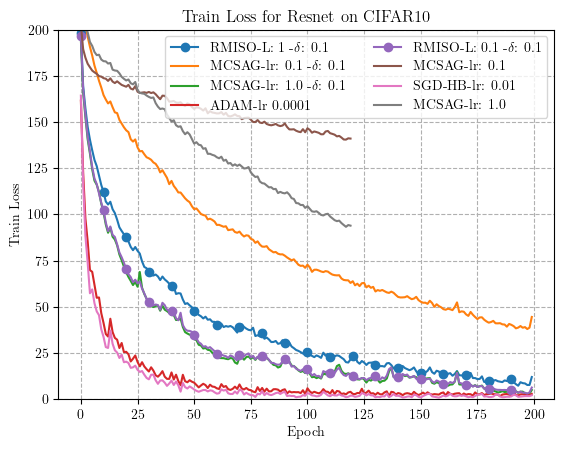

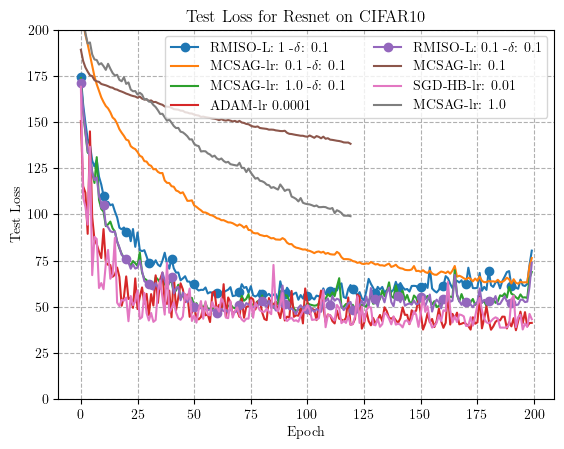

In [8]:
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(0, 200)
     , curve_type='train_loss', algorithm="metropolis_hastings")
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(0, 200), 
     curve_type='test_loss', algorithm="metropolis_hastings")

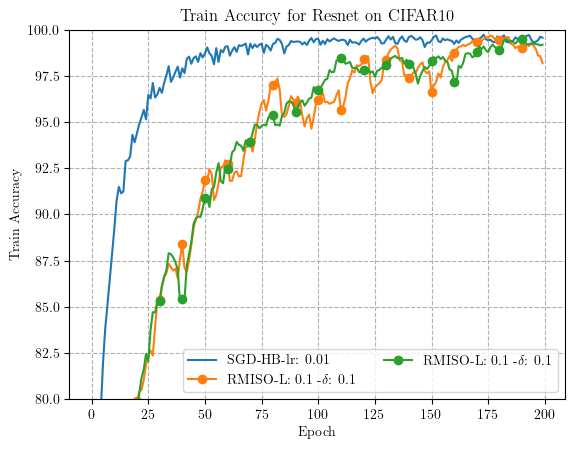

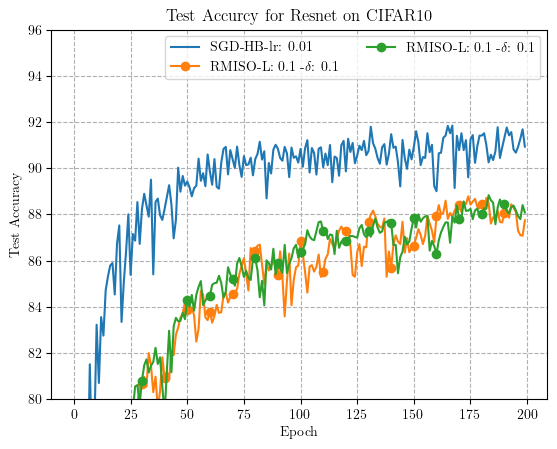

In [9]:
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(80, 100)
     , curve_type='train_acc', algorithm="random_walk")
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(80, 96), 
     curve_type='test_acc', algorithm="random_walk")

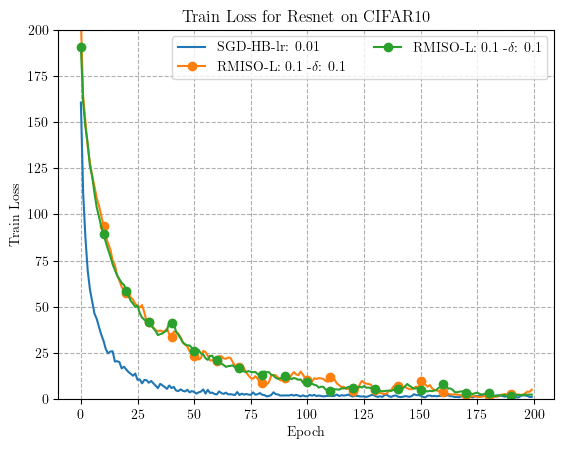

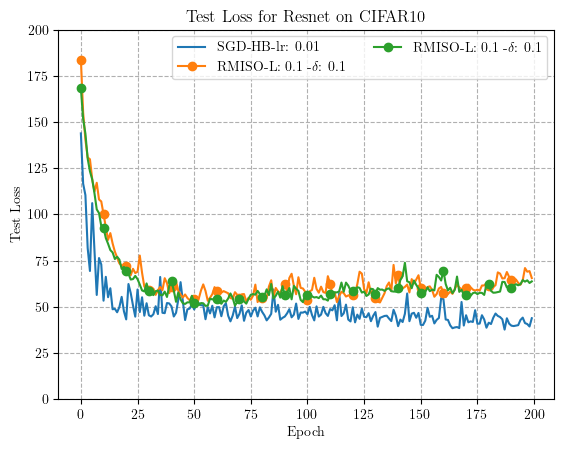

In [10]:
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(0, 200)
     , curve_type='train_loss', algorithm="random_walk")
plot(use_pretrained=False, model='resnet', optimizers={"rmiso": [10,1], "sgd": [1e-2], "adam": [1e-4], "mcsag": [1, 0.1]}, ylim=(0, 200), 
     curve_type='test_loss', algorithm="random_walk")

In [10]:
def plot_alg_compare(use_pretrained=True, model='one_layer', optimizers=None, title=None, ylim=(50, 100), curve_type='train'):
    curve_data = get_curve_data(use_pretrained, model=model)
    
    plt.figure()
    if curve_type.split("_")[1] == "acc":
        if title is None:
            title = '{} Accurcy for {} on CIFAR10'.format(curve_type.split("_")[0].capitalize(), model.capitalize())
        plt.ylabel('{} Accuracy %'.format(curve_type.split("_")[0].capitalize()))
    else:
        if title is None:
            title = '{} Loss for {} on CIFAR10'.format(curve_type.split("_")[0].capitalize(), model.capitalize())
        plt.ylabel('{} Loss'.format(curve_type.split("_")[0].capitalize()))

    plt.title(title)
    plt.xlabel('Epoch')
    plt.xlim(0, 120)
    plt.ylim(ylim)
    
    for curve in curve_data:
        optim = curve['optim']
        lr = curve['lr']
        alg = curve['alg']
        linestyle = '-' if 'rmiso' in optim else '-'
        marker = 'o' if 'rmiso' in optim else ''
        if 'SMM' in optim:
            marker = '*'
        
        if optim in optimizers.keys() and lr in optimizers[optim]:
            accuracies = np.array(curve['curve'][curve_type])
            if optim == "rmiso":
                initial_lr = None
                final_lr = None
                try:
                    initial_lr = curve['hyp_params'][2][10:]
                    final_lr = curve['hyp_params'][3][8:]
                except IndexError:
                    pass
                delta = curve['hyp_params'][1][5:]
                rho = curve['hyp_params'][0][3:]
                L = 1/lr
                if alg == 'uniform':
                    if float(rho) == 0:
                        label = r"MISO-L: {:.4g}".format(L)
                    else:
                        label = r"RMISO-L: {:.4g} - $\rho$: {:.4g}".format(L, float(rho))
                else:
                    label = r"RMISO-L: {:.4g} -$\delta$: {:.4g}".format(L, float(delta))
            elif optim == "sgd":
                label = "SGD-HB-lr: {}".format(lr)
            elif optim =="mcsag":
                if alg == 'uniform':
                    label = "SAG-lr: {}".format(lr)
                else:
                    try:
                        delta = curve['hyp_params'][1][5:]
                        label = r"MCSAG-lr: {} -$\delta$: {:.4g}".format(lr, float(delta))
                    except IndexError:
                        label =r"MCSAG-lr: {}".format(lr)
                        #pass
            else:
                label = f"{optim.upper()}-lr {lr}"
            
            label = label + "alg: {}".format(alg)
            plt.plot(accuracies, label=label, ls=linestyle, marker=marker, markevery=10)
        

        
    plt.grid(ls='--')
    plt.legend(ncol=2)
    plt.show()    


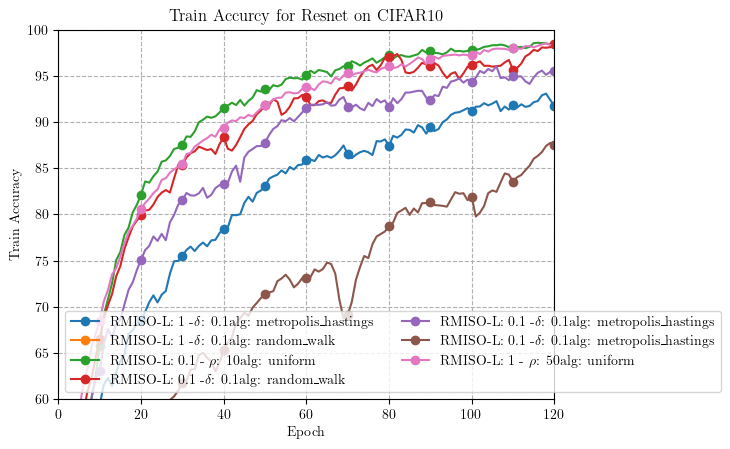

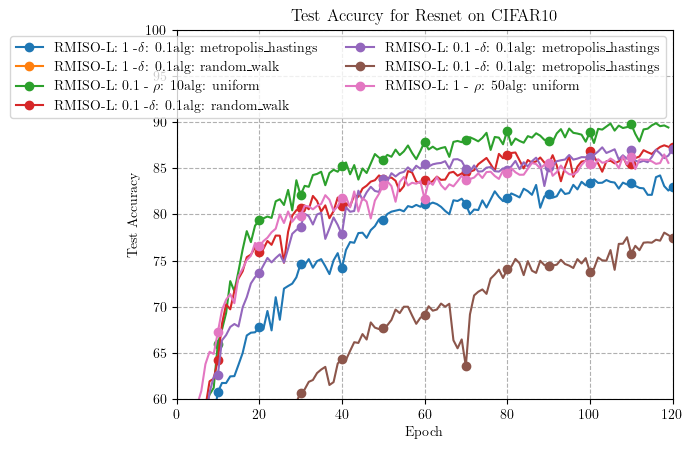

In [12]:
plot_alg_compare(use_pretrained=False, model='resnet', optimizers={"rmiso": [10, 1]}, ylim=(60, 100)
     , curve_type='train_acc')
plot_alg_compare(use_pretrained=False, model='resnet', optimizers={"rmiso": [10, 1]}, ylim=(60, 100), 
     curve_type='test_acc')

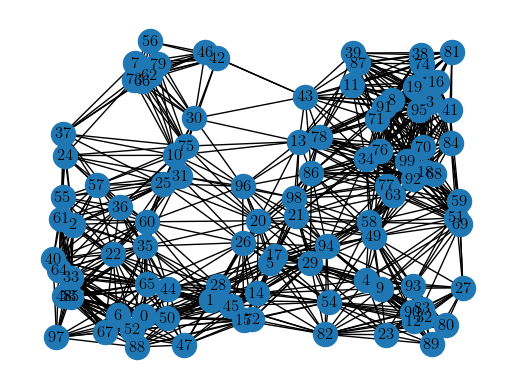

In [14]:
from graph_structure.data_graph import plot_graph
fig, ax = plot_graph(100, radius=0.3, topo="geometric")